In [12]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
import matplotlib.pyplot as plt


In [13]:

# Load the datasets
train = pd.read_csv("/Users/jyothi/Desktop/santender/train.csv")
test = pd.read_csv("/Users/jyothi/Desktop/santender/test.csv")

In [14]:
train_y = train['TARGET']
train_x = train
train_x.drop(['ID', 'TARGET'], axis=1, inplace=True)
test_id = test['ID']
del test['ID']

In [15]:
# Fixing the outliers in column 'var3'
train_x['var3'].replace(-999999,0, inplace=True)
test['var3'].replace(-999999,0, inplace=True)

# Remove all the columns which have constant values. 
# These columns have zero std deviation.
rm_col=[] 
for col in train_x.columns:
    if train_x[col].std()==0:
        rm_col.append(col)

train_x.drop(rm_col, axis=1, inplace=True)
test.drop(rm_col, axis=1, inplace=True)

In [16]:
# Remove the duplicate columns. 
# Here we have columns with different name but exactly same values for each rows
# We will compare each columns with all other columns
dups_col = []
for ii in range(len(train_x.columns)-1):
    for jj in range(ii+1,len(train_x.columns)):
        col1=train_x.columns[ii]
        col2=train_x.columns[jj]
        # take the columns as arrays adn then compare the values.
        if np.array_equal(train_x[col1].values, train_x[col2].values) and not col2 in dups_col:
            dups_col.append(col2)

train_x.drop(dups_col, axis=1, inplace=True)
test.drop(dups_col, axis=1, inplace=True)

In [17]:
# Define a classifier
rf_clf = RandomForestClassifier(max_depth=15,n_estimators=70, min_samples_leaf=50,
                                  min_samples_split=100, random_state=10)

# Train the model
rf_clf.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=50,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=70, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

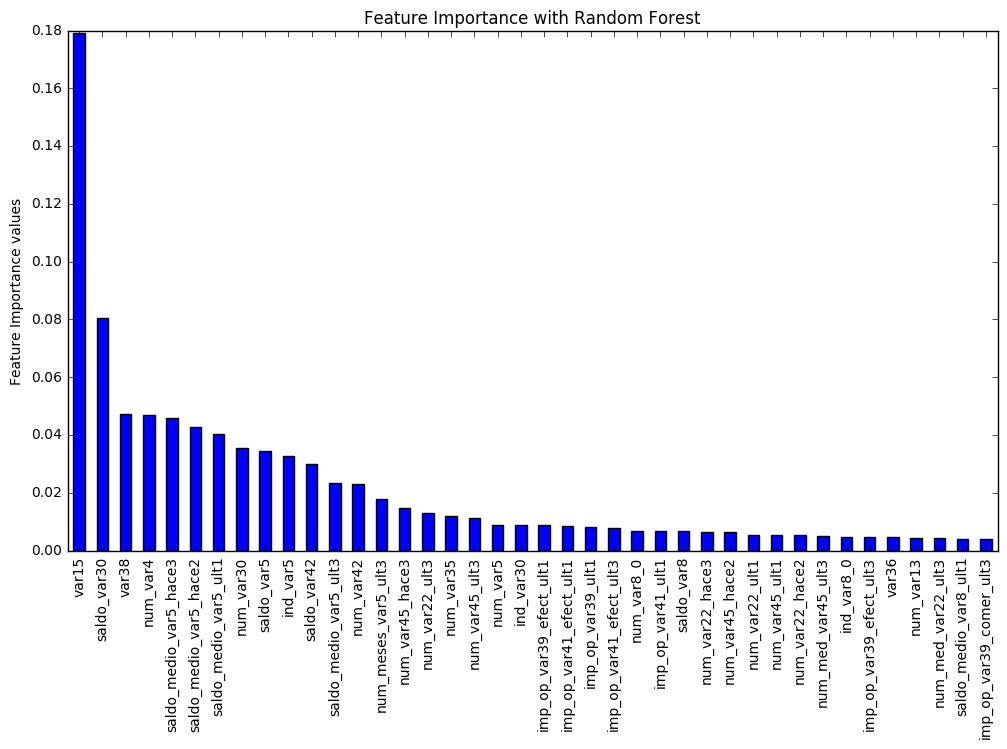

In [18]:
# Plot the top 40 important features
imp_feat_rf = pd.Series(rf_clf.feature_importances_, index=train_x.columns).sort_values(ascending=False)
imp_feat_rf[:40].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.savefig('FeatImportance.png')
plt.show()

In [20]:

# Save indexes of the important features in descending order of their importance
indices = np.argsort(rf_clf.feature_importances_)[::-1]

In [21]:
# list the names of the names of top 40 selected features adn remove the unicode
select_base =[str(s) for s in train_x.columns[indices][:50]]

# Make the subsets with 40 features only
train_x_sub = train_x[select_base]
test_sub = test[select_base]

#### We will use GridSearch package with cross validation to find best estimators from a list of parameters
# Define a new Random Forest Classifier
select_rf_clf = RandomForestClassifier(random_state=10)

param_grid = {
    
            'n_estimators': [50, 80, 100],
            'max_depth': [5,10, 15]
}

In [24]:
# we will 10-fold cross-validation
grid_clf = GridSearchCV(select_rf_clf,param_grid,cv=5)
grid_clf.fit(train_x_sub,train_y)

# Take the best model
best_rf_clf = grid_clf.best_estimator_

# Make prediction with test data
predicted_proba = best_rf_clf.predict_proba(train_x_sub)

In [32]:
import numpy as np 
import pandas as pd 
import matplotlib

import matplotlib.pyplot as plt

 
from sklearn import cross_validation
import sklearn
from  sklearn.metrics import roc_cur
from sklearn.metrics import roc_auc_score

In [29]:
print('Overall AUC:', roc_auc_score(train_y, predicted_proba[:,1]))


Overall AUC: 0.882347253413


In [36]:
from sklearn.metrics import roc_auc_score
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(train_y, predicted_proba[:,1])
roc_auc = sklearn.metrics.auc(false_positive_rate, true_positive_rate)

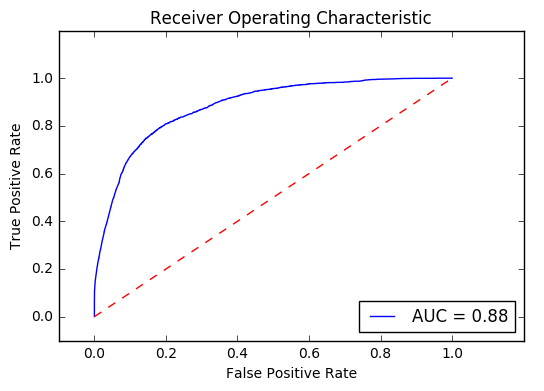

In [37]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()